In [21]:
# Step 1: Import required libraries
import os, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


In [2]:
# ==========================================================
# Step 1: Checking directory structure for making CSV file
# ==========================================================

# Step 2: Define main directory and CSV path
main_dir = "dataset_4_100img"   # 🔸 change to your folder path
csv_path = os.path.join(main_dir, "image_data.csv")

# Step 3: Check if CSV file exists
if os.path.exists(csv_path):
    print("✅ CSV file already exists. Loading...")
    df = pd.read_csv(csv_path)
else:
    print("⚙️ CSV not found. Creating new one...")

    file_paths = []
    labels = []

    # Walk through folders and collect file paths
    for label in os.listdir(main_dir):
        class_dir = os.path.join(main_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths.append(os.path.join(class_dir, file))
                    labels.append(label)

    # Create DataFrame
    df = pd.DataFrame({
        'filename': file_paths,
        'class': labels
    })

    # Save to CSV
    df.to_csv(csv_path, index=False)
    print(f"✅ CSV file created successfully at: {csv_path}")

print(df.head())
print(f"Total images found: {len(df)}")


⚙️ CSV not found. Creating new one...
✅ CSV file created successfully at: dataset_4_100img/image_data.csv
                                            filename           class
0  dataset_4_100img/Bacterial_Pneu/Pneumonia-Bact...  Bacterial_Pneu
1  dataset_4_100img/Bacterial_Pneu/Pneumonia-Bact...  Bacterial_Pneu
2  dataset_4_100img/Bacterial_Pneu/Pneumonia-Bact...  Bacterial_Pneu
3  dataset_4_100img/Bacterial_Pneu/Pneumonia-Bact...  Bacterial_Pneu
4  dataset_4_100img/Bacterial_Pneu/Pneumonia-Bact...  Bacterial_Pneu
Total images found: 467


In [3]:

# Step 4: Split into train, validation, test (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Step 5: Create ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Step 6: Create generators
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Data generators ready to use for model training.")


Train: 373, Validation: 47, Test: 47
Found 373 validated image filenames belonging to 4 classes.
Found 47 validated image filenames belonging to 4 classes.
Found 47 validated image filenames belonging to 4 classes.

✅ Data generators ready to use for model training.


In [4]:
# ==========================================================
# Step 7: Data Visualization
# ==========================================================

In [5]:
def plot_class_distribution(df, title):
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='class', order=df['class'].value_counts().index, palette='viridis')
    plt.title(title, fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


📊 Class Distribution in Training, Validation & Test Sets:


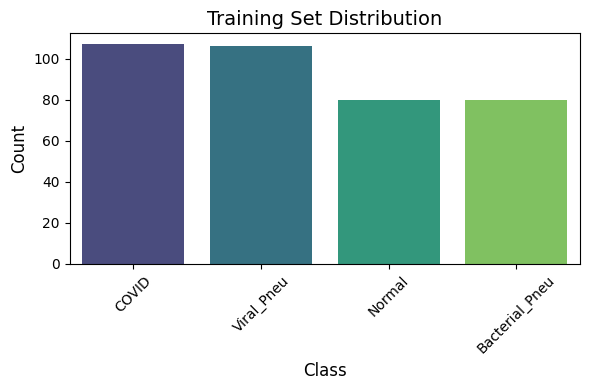

In [6]:

print("📊 Class Distribution in Training, Validation & Test Sets:")
plot_class_distribution(train_df, "Training Set Distribution")


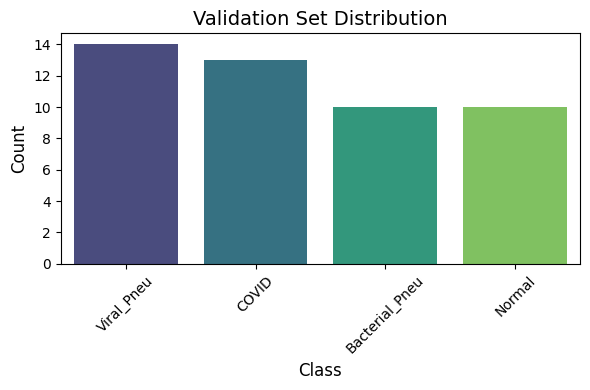

In [7]:
plot_class_distribution(val_df, "Validation Set Distribution")

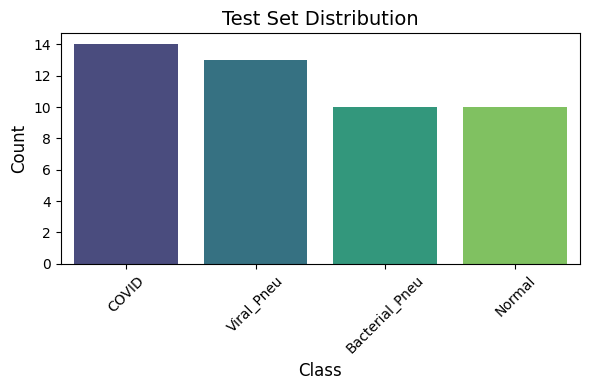

In [8]:
plot_class_distribution(test_df, "Test Set Distribution")

🖼️ Random Image Samples:


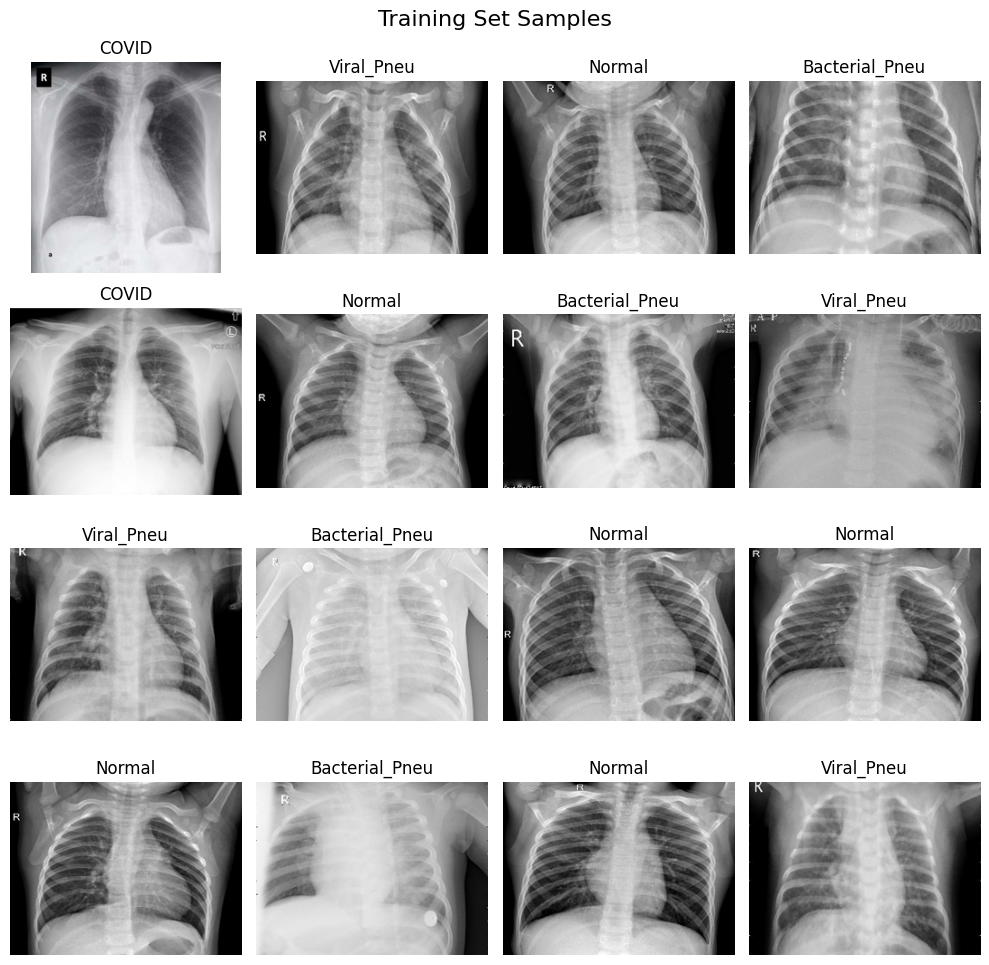

In [9]:
# ---- (B) Visualize random image samples ----
def show_random_images(df, num_images=16, title="Random Samples"):
    sample_df = df.sample(num_images)
    plt.figure(figsize=(10,10))
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        plt.subplot(4, 4, i+1)
        img = Image.open(row['filename'])
        plt.imshow(img)
        plt.title(row['class'])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

print("🖼️ Random Image Samples:")
show_random_images(train_df, title="Training Set Samples")

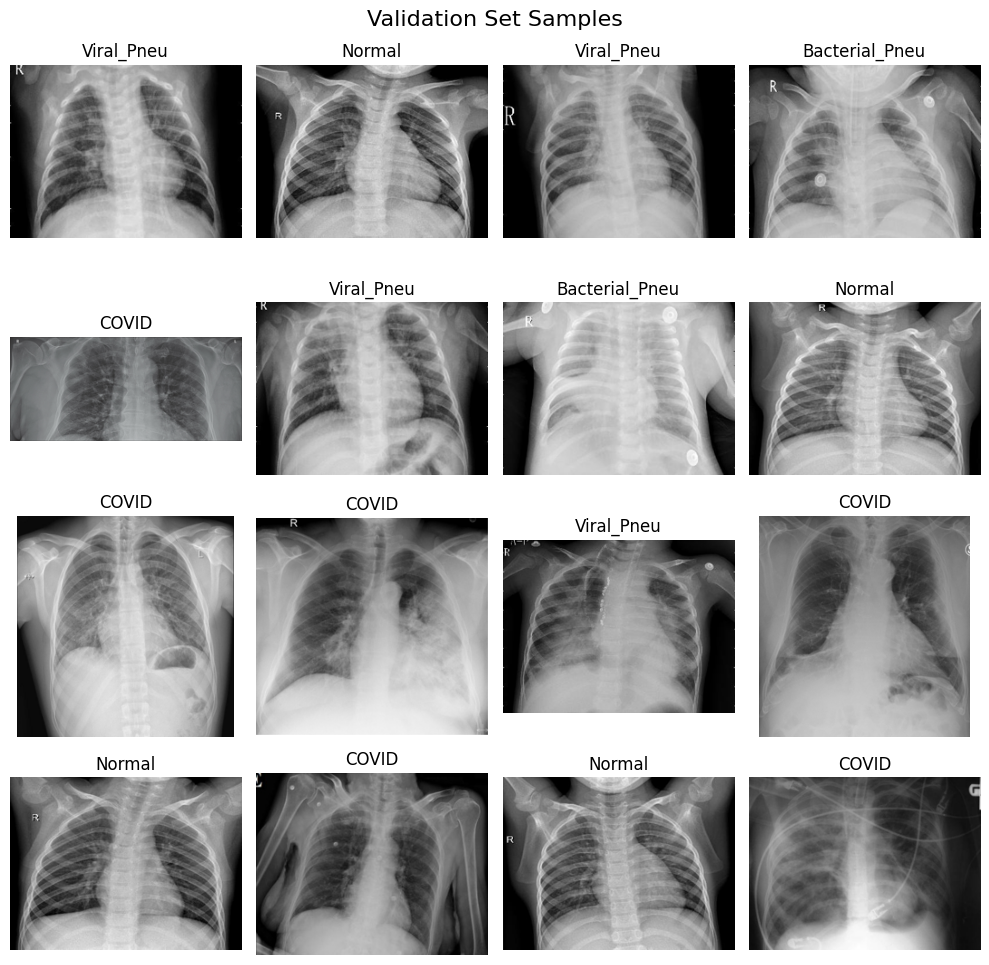

In [10]:
show_random_images(val_df, title="Validation Set Samples")


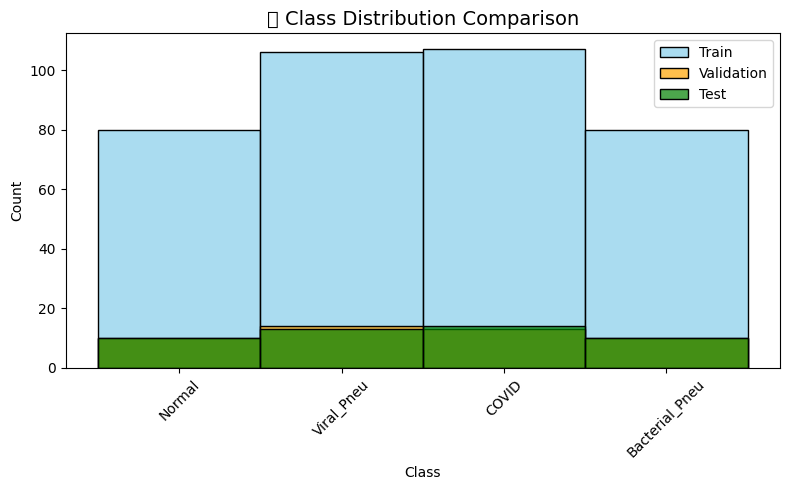

In [12]:
# ---- (C) Optional: Combined Distribution Comparison ----
def compare_distributions(train_df, val_df, test_df):
    plt.figure(figsize=(8,5))
    sns.histplot(train_df['class'], color='skyblue', label='Train', stat='count', alpha=0.7)
    sns.histplot(val_df['class'], color='orange', label='Validation', stat='count', alpha=0.7)
    sns.histplot(test_df['class'], color='green', label='Test', stat='count', alpha=0.7)
    plt.title("📊 Class Distribution Comparison", fontsize=14)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

compare_distributions(train_df, val_df, test_df)

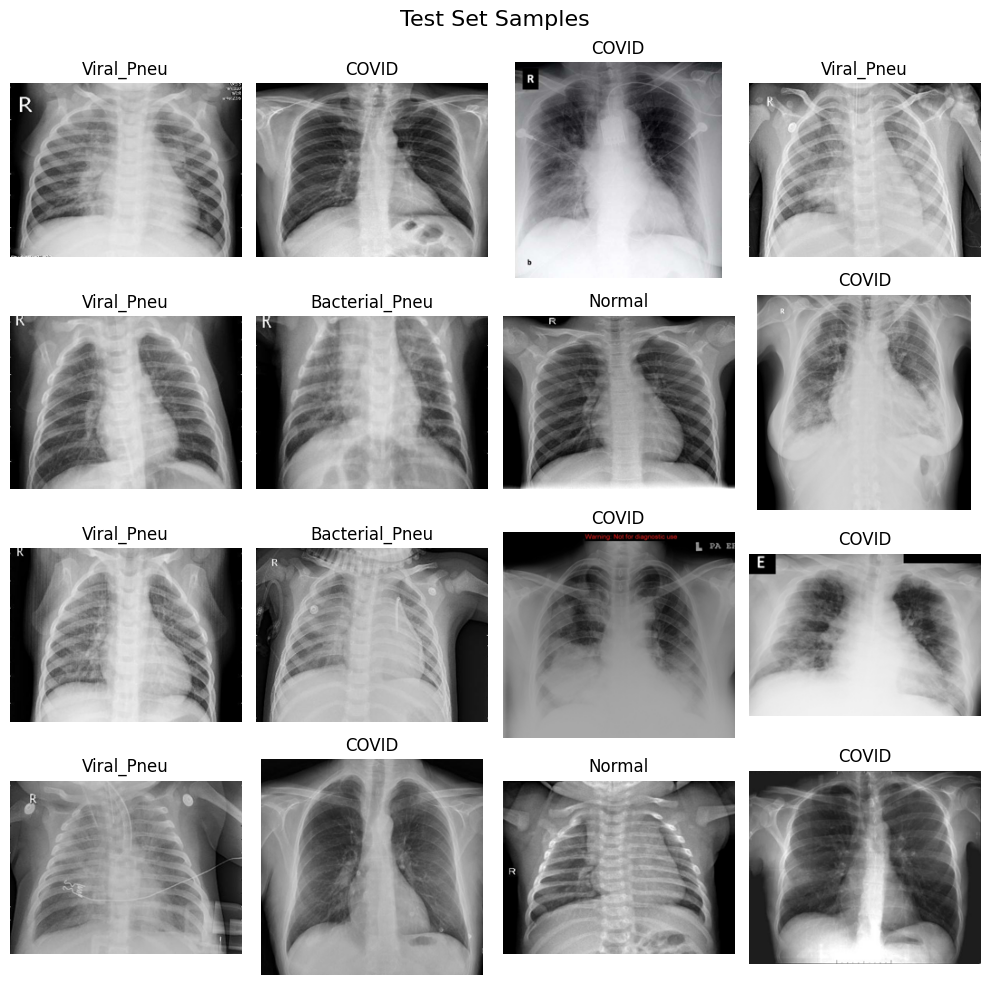

In [11]:
show_random_images(test_df, title="Test Set Samples")

In [13]:
# ==========================================================
# Step 8: Generator Information
# ==========================================================

def display_generator_info(train_gen, val_gen, test_gen):
    """Display dataset summary and generator configuration details."""
    print("\n" + "="*60)
    print("🧾 DATA GENERATOR INFORMATION")
    print("="*60)

    # 1️⃣ Total samples in each generator
    print(f"Training samples:     {train_gen.samples}")
    print(f"Validation samples:   {val_gen.samples}")
    print(f"Testing samples:      {test_gen.samples}")

    # 2️⃣ Class information
    print("\n🔸 Classes found:")
    for class_name, class_index in train_gen.class_indices.items():
        print(f"   {class_name} → {class_index}")

    # 3️⃣ Number of classes
    num_classes = len(train_gen.class_indices)
    print(f"\nTotal Classes: {num_classes}")

    # 4️⃣ Image properties
    print(f"Image Target Size: {train_gen.target_size}")
    print(f"Batch Size: {train_gen.batch_size}")
    print(f"Color Mode: {train_gen.color_mode}")
    print(f"Shuffle: {train_gen.shuffle}")

    # 5️⃣ Example batch inspection
    x_batch, y_batch = next(train_gen)
    print(f"\nSample batch shape: X={x_batch.shape}, Y={y_batch.shape}")

    print("="*60)
    print("✅ Generator summary printed successfully.")
    print("="*60)

# Run this function
display_generator_info(train_gen, val_gen, test_gen)


🧾 DATA GENERATOR INFORMATION
Training samples:     373
Validation samples:   47
Testing samples:      47

🔸 Classes found:
   Bacterial_Pneu → 0
   COVID → 1
   Normal → 2
   Viral_Pneu → 3

Total Classes: 4
Image Target Size: (224, 224)
Batch Size: 32
Color Mode: rgb
Shuffle: True

Sample batch shape: X=(32, 224, 224, 3), Y=(32, 4)
✅ Generator summary printed successfully.


In [14]:
# ==========================================================
# Step 9: Model Creation
# ==========================================================

def build_cnn_model(input_shape, num_classes):
    """Construct a simple CNN architecture and compile the model."""
    
    model = Sequential([
        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Flatten + Dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\n✅ CNN model created and compiled successfully.")
    model.summary()
    return model


# Run the function using your generator data
input_shape = (224, 224, 3)
num_classes = len(train_gen.class_indices)

model = build_cnn_model(input_shape, num_classes)


✅ CNN model created and compiled successfully.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
        

In [15]:
# ==========================================================
# Step 10: Model Training
# ==========================================================

def train_model(model, train_gen, val_gen, epochs=20):
    """Train the CNN model with early stopping and checkpoint saving."""
    
    # ✅ Define callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    # ✅ Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    print("\n✅ Model training completed successfully.")
    return history


# Run training
EPOCHS = 100
history = train_model(model, train_gen, val_gen, epochs=EPOCHS)

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 22.1170 - accuracy: 0.5455
Epoch 1: val_accuracy improved from -inf to 0.36170, saving model to best_model.h5
12/12 [==============================] - 6s 208ms/step - loss: 20.8140 - accuracy: 0.5603 - val_loss: 1.7939 - val_accuracy: 0.3617
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 6.3905 - accuracy: 0.7346
Epoch 2: val_accuracy did not improve from 0.36170
12/12 [==============================] - 1s 59ms/step - loss: 6.3905 - accuracy: 0.7346 - val_loss: 8.6757 - val_accuracy: 0.2979
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 2.8933 - accuracy: 0.7159
Epoch 3: val_accuracy did not improve from 0.36170
12/12 [==============================] - 1s 60ms/step - loss: 2.7749 - accuracy: 0.7185 - val_loss: 17.7614 - val_accuracy: 0.2979
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 1.1567 - accuracy: 0.7625
Epoch 4: val_accuracy did not improve fro

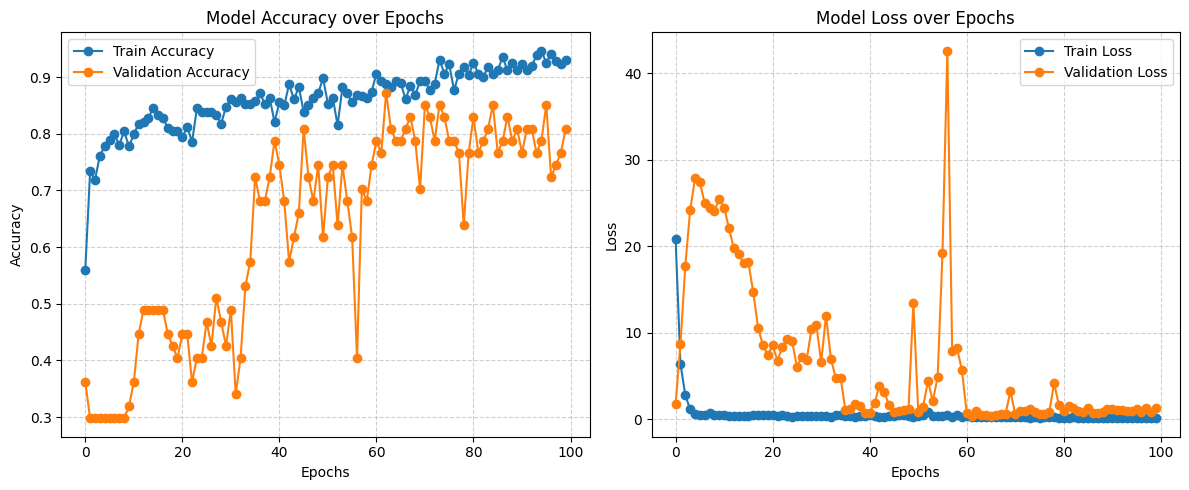

In [16]:
# ==========================================================
# Step 11: TRAINING HISTORY VISUALIZATION
# ==========================================================
import matplotlib.pyplot as plt

# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))

# ------------------------------
# 1️⃣ Accuracy Curve
# ------------------------------
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# ------------------------------
# 2️⃣ Loss Curve
# ------------------------------
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

Found 47 validated image filenames belonging to 4 classes.
2/2 [==============================] - 0s 25ms/step


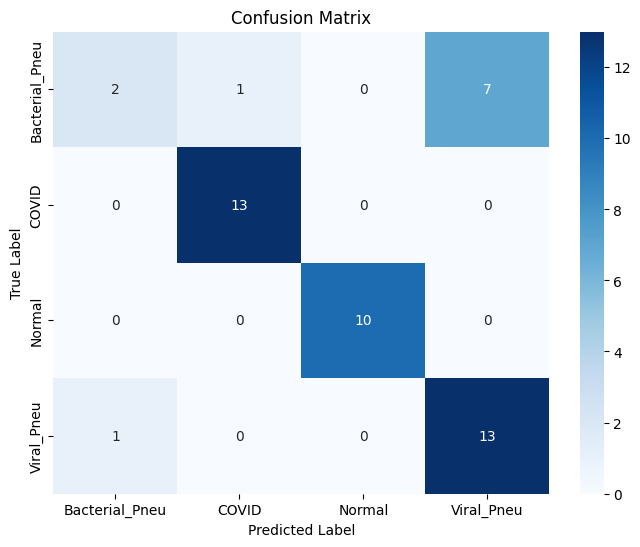

=== Classification Report ===
                precision    recall  f1-score   support

Bacterial_Pneu       0.67      0.20      0.31        10
         COVID       0.93      1.00      0.96        13
        Normal       1.00      1.00      1.00        10
    Viral_Pneu       0.65      0.93      0.76        14

      accuracy                           0.81        47
     macro avg       0.81      0.78      0.76        47
  weighted avg       0.81      0.81      0.77        47



In [17]:
# ==========================================================
# Step 12: MODEL EVALUATION
# ==========================================================
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # <- disable shuffle!
)


# Generate predictions for the validation set
val_steps = len(val_gen)
y_pred_probs = model.predict(val_gen, steps=val_steps, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

# Get class labels from the generator
class_labels = list(val_gen.class_indices.keys())

# ------------------------------
# 1️⃣ Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ------------------------------
# 2️⃣ Classification Report
# ------------------------------
print("=== Classification Report ===")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


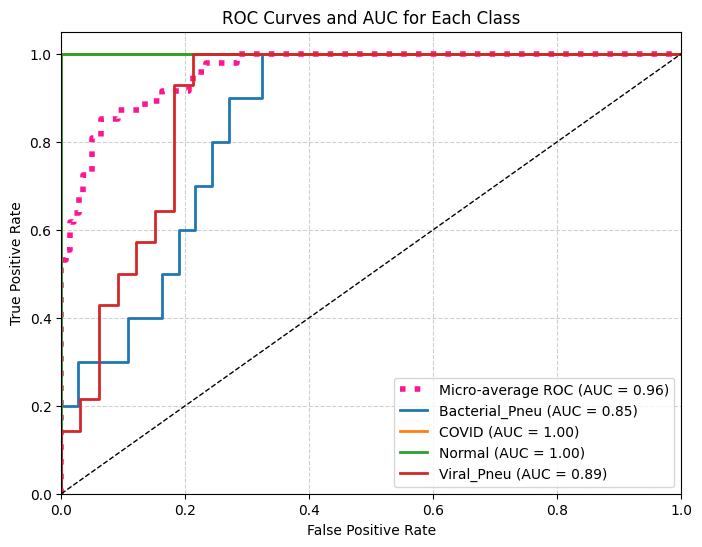

In [18]:
# ==========================================================
# Step 13: ROC–AUC ANALYSIS
# ==========================================================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ------------------------------
# Binarize the true labels
# ------------------------------
n_classes = len(class_labels)
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

# ------------------------------
# Compute ROC curve and AUC for each class
# ------------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ------------------------------
# Compute micro-average ROC curve and AUC
# ------------------------------
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ------------------------------
# Plot all ROC curves
# ------------------------------
plt.figure(figsize=(8, 6))

# Micro-average curve (overall performance)
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Individual class curves
colors = plt.cm.tab10.colors
for i, class_name in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves and AUC for Each Class')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


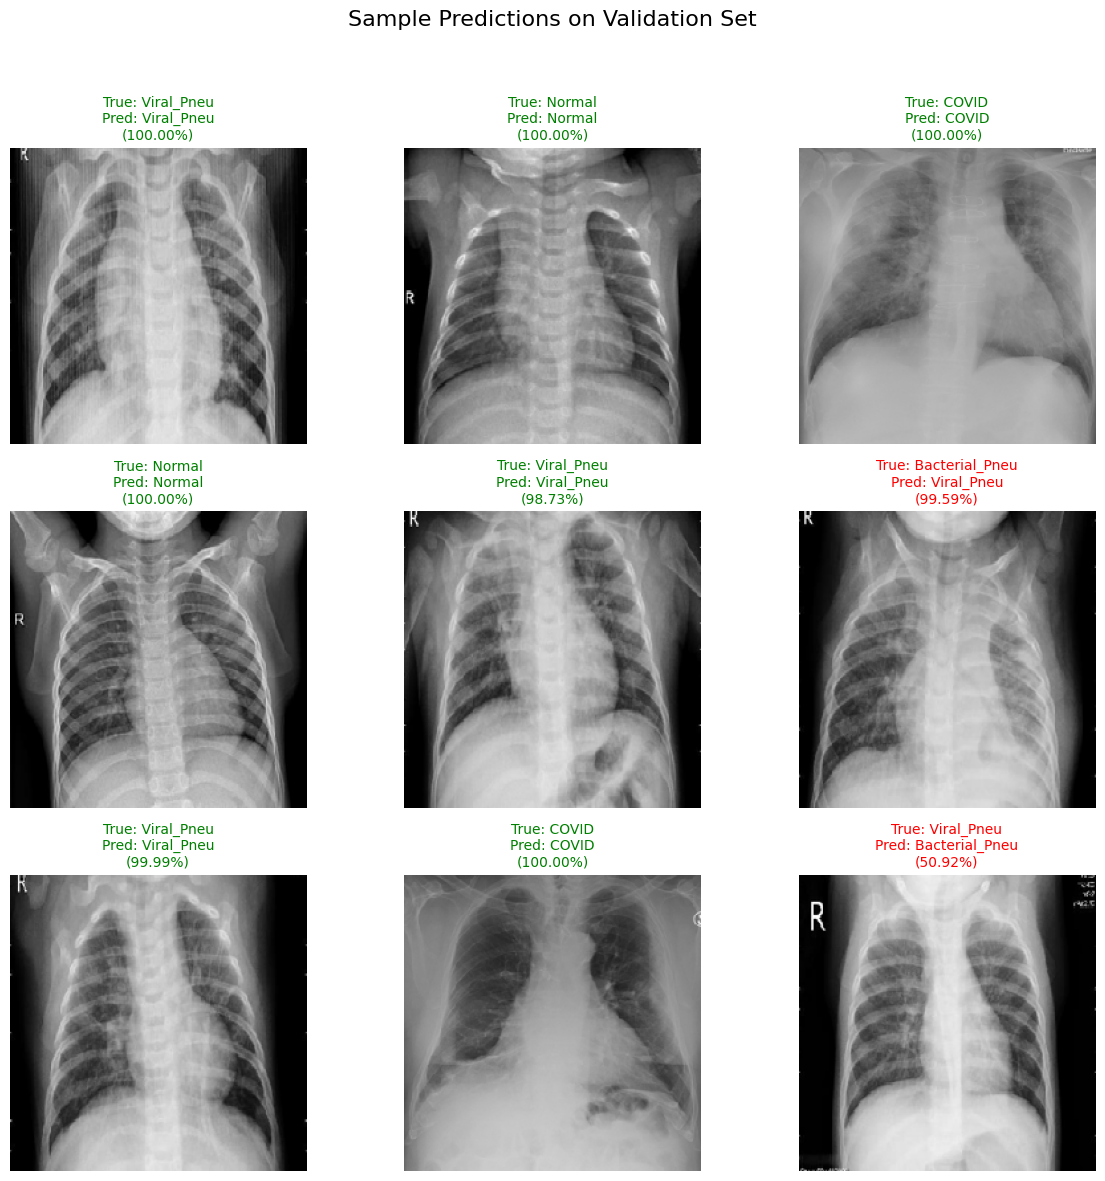

In [19]:
# ==========================================================
# Step 14: SAMPLE PREDICTIONS VISUALIZATION (Guaranteed Working)
# ==========================================================

num_samples = 9
random_indices = np.random.choice(len(val_df), num_samples, replace=False)
sample_df = val_df.iloc[random_indices]

plt.figure(figsize=(12, 12))

for i, (_, row) in enumerate(sample_df.iterrows(), 1):
    img_path = row['filename']
    true_class = row['class']

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_batch, verbose=0)
    predicted_class_index = np.argmax(preds)
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(preds) * 100

    # Plot
    plt.subplot(3, 3, i)
    plt.imshow(img_array)
    plt.title(
        f"True: {true_class}\nPred: {predicted_class}\n({confidence:.2f}%)",
        fontsize=10,
        color='green' if true_class == predicted_class else 'red'
    )
    plt.axis('off')

plt.suptitle("Sample Predictions on Validation Set", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


🔍 Evaluating model on validation set...

Found 47 validated image filenames belonging to 4 classes.
✅ Exact Validation Accuracy: 0.8085

=== Classification Report ===
                precision    recall  f1-score   support

Bacterial_Pneu       0.67      0.20      0.31        10
         COVID       0.93      1.00      0.96        13
        Normal       1.00      1.00      1.00        10
    Viral_Pneu       0.65      0.93      0.76        14

      accuracy                           0.81        47
     macro avg       0.81      0.78      0.76        47
  weighted avg       0.81      0.81      0.77        47



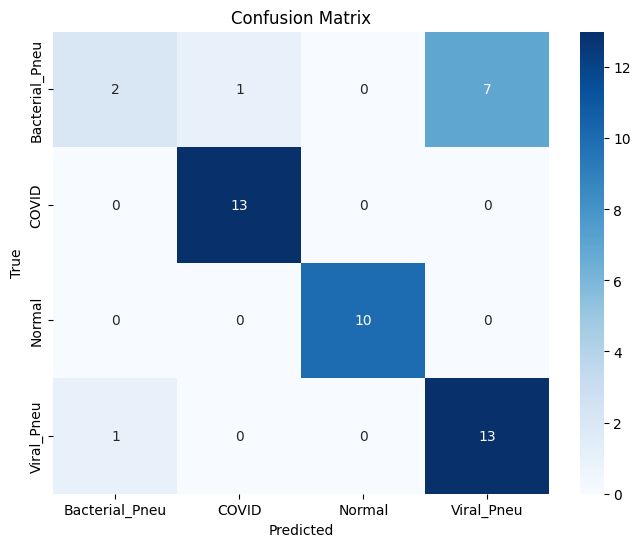


=== ROC-AUC CURVES ===


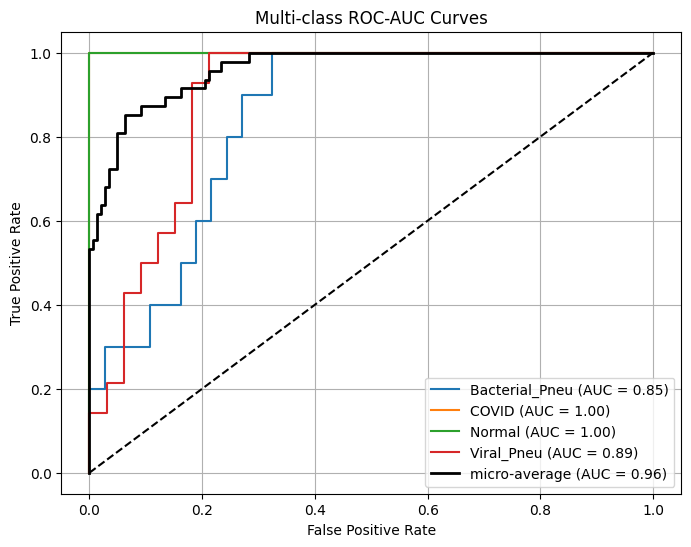


=== Summary Metrics ===


,precision,recall,f1-score,support
Bacterial_Pneu,0.667,0.200,0.308,10.000
COVID,0.929,1.000,0.963,13.000
Normal,1.000,1.000,1.000,10.000
Viral_Pneu,0.650,0.929,0.765,14.000
accuracy,0.809,0.809,0.809,0.809
macro avg,0.811,0.782,0.759,47.000
weighted avg,0.805,0.809,0.772,47.000


In [20]:
# ==========================================================
# 📊 MODEL EVALUATION DASHBOARD
# ==========================================================
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model_dashboard(model, val_df, class_labels, img_size=(224, 224), batch_size=32):
    """
    Complete evaluation block that:
      1. Recreates validation generator without shuffling
      2. Computes predictions & metrics
      3. Displays confusion matrix, classification report, ROC-AUC curves
    """

    print("🔍 Evaluating model on validation set...\n")

    # Recreate the validation generator (no shuffle)
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_gen_eval = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Predict
    y_probs = model.predict(val_gen_eval, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = val_gen_eval.classes

    # Accuracy
    exact_acc = accuracy_score(y_true, y_pred)
    print(f"✅ Exact Validation Accuracy: {exact_acc:.4f}\n")

    # Classification Report
    print("=== Classification Report ===")
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC-AUC Analysis
    print("\n=== ROC-AUC CURVES ===")
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

    # Micro-average ROC
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, label=f"micro-average (AUC = {roc_auc_micro:.2f})", color='black', lw=2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC-AUC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Summary Table
    summary_df = pd.DataFrame(report).T
    print("\n=== Summary Metrics ===")
    display(summary_df.round(3))

    return {
        "accuracy": exact_acc,
        "report": summary_df,
        "confusion_matrix": cm
    }

# ==========================================================
# 🧠 RUN THE EVALUATION
# ==========================================================
results = evaluate_model_dashboard(model, val_df, class_labels, img_size=(224, 224), batch_size=32)
